# (07) Readout: 3D conv

**Motivation**: Did not work. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from analysis.opticflow import *
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
from rich.jupyter import print
%matplotlib inline
set_style()

## Spatiotemporal $\Rightarrow$ Linear

In [2]:
from base.common import Conv2D, print_num_params, nn

In [4]:
x = torch.randn(500, 128, 4, 4)
x_t = torch.transpose(x, 0, 1)
x_t = x_t.unsqueeze(0)
x_t.size()

torch.Size([1, 128, 500, 4, 4])

In [5]:
kernel_full = nn.Conv3d(128, 1, kernel_size=[12, 4, 4])
y = kernel_full(x_t)
x_t.size(), y.size()

(torch.Size([1, 128, 500, 4, 4]), torch.Size([1, 1, 489, 1, 1]))

In [6]:
print_num_params(kernel_full)

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    Conv3d   |   24.6 K   |
|     ---     |    ---     |
+-------------+------------+

In [7]:
x_t = torch.transpose(x, 0, 1)
x_t = x_t.unsqueeze(1)
x_t.size()

torch.Size([128, 1, 500, 4, 4])

In [8]:
kernel_lite = nn.Conv3d(1, 1, kernel_size=[20, 4, 4])
y = kernel_lite(x_t)
x_t.size(), y.size()

(torch.Size([128, 1, 500, 4, 4]), torch.Size([128, 1, 481, 1, 1]))

In [9]:
print_num_params(kernel_lite)

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    Conv3d   |    321     |
|     ---     |    ---     |
+-------------+------------+

## Example tker

(21,)

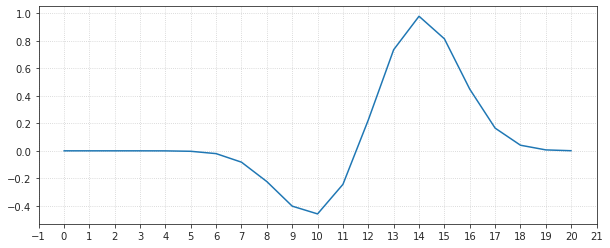

In [10]:
x = np.linspace(0, 20, 21)
y1 = np.exp(-(x - 14)**2 / 5)
y2 = -0.5 * np.exp(-(x - 10)**2 / 5)
y = y1 + y2

fig, ax = create_figure(figsize=(10, 4))
ax.plot(y)
ax.locator_params(axis='x', nbins=24)
ax.grid();

y.shape

In [11]:
tker = torch.Tensor(y).unsqueeze(0).unsqueeze(0)
c = nn.Conv1d(1, 1, len(y), padding=10)
c.weight.data = tker

In [12]:
x = torch.zeros(1000)
x[700] = 1
x = x.view(1, 1, -1)
x.size()

torch.Size([1, 1, 1000])

In [13]:
out = c(x)
out = to_np(out.squeeze())
out.shape

(1000,)

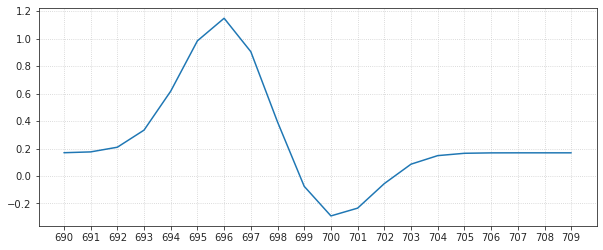

In [14]:
fig, ax = create_figure(figsize=(10, 4))

intvl = range(690, 710)
ax.plot(intvl, out[intvl])
ax.locator_params(axis='x', nbins=25)
ax.grid();

In [15]:
x = np.zeros(1000)
x[700:721] = y
x = torch.tensor(x, dtype=torch.float)
x = x.view(1, 1, -1)
x.size()

torch.Size([1, 1, 1000])

In [16]:
out = c(x)
out = to_np(out.squeeze())
out.shape

(1000,)

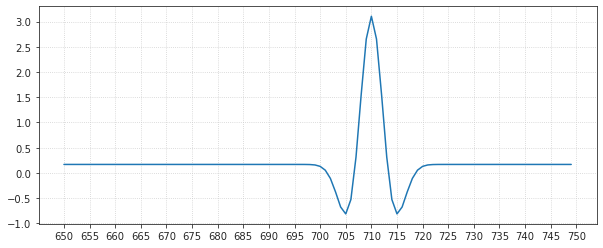

In [17]:
fig, ax = create_figure(figsize=(10, 4))

intvl = range(650, 750)# range(690, 710)
ax.plot(intvl, out[intvl])
ax.locator_params(axis='x', nbins=25)
ax.grid();

### Causal temporal conv

In [20]:
tker = torch.Tensor(y).unsqueeze(0).unsqueeze(0)
c = nn.Conv1d(1, 1, len(y), padding=len(y) - 1)
c.weight.data = tker

In [21]:
x = torch.zeros(1000)
x[700] = 1
x = x.view(1, 1, -1)
x.size()

torch.Size([1, 1, 1000])

In [22]:
out = c(x)
out = to_np(out.squeeze())
out.shape

(1020,)

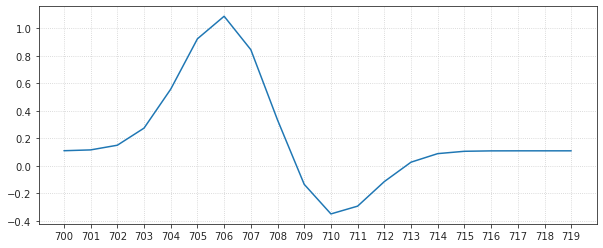

In [23]:
fig, ax = create_figure(figsize=(10, 4))

intvl = range(700, 720)
ax.plot(intvl, out[intvl])
ax.locator_params(axis='x', nbins=25)
ax.grid();

In [24]:
x = np.zeros(1000)
x[700:721] = y
x = torch.tensor(x, dtype=torch.float)

out = c(x.view(1, 1, -1))
out = to_np(out.squeeze())
out.shape

(1020,)

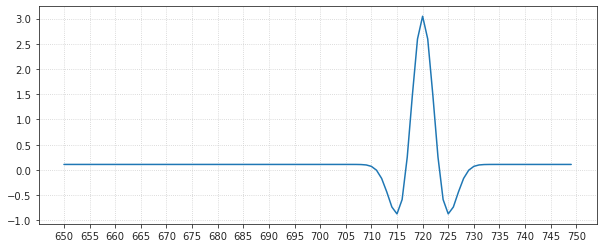

In [25]:
fig, ax = create_figure(figsize=(10, 4))

intvl = range(650, 750)# range(690, 710)
ax.plot(intvl, out[intvl])
ax.locator_params(axis='x', nbins=25)
ax.grid();

In [26]:
x = torch.randn(1000, 128, 4, 4)
x_t = torch.movedim(x, 0, -1)
x_t = x_t.unsqueeze(1)
x_t.size()

torch.Size([128, 1, 4, 4, 1000])

In [27]:
pad = len(y) - 1
kernel_lite = nn.Conv3d(1, 1, kernel_size=[4, 4, len(y)], padding=[0, 0, pad])
out_raw = kernel_lite(x_t)
out = out_raw.squeeze()[..., :-pad].T.contiguous()

out_raw.size(), out.size()

(torch.Size([128, 1, 1, 1, 1020]), torch.Size([1000, 128]))

## ftr sizes

In [4]:
n_ftrs_enc, n_ftrs_dec = vae.ftr_sizes()
n_ftrs_enc, n_ftrs_dec

({8: 2624, 4: 2688}, {4: 2304, 8: 2624})

In [5]:
x, _ = next(iter(tr.dl_tst))
*_, ftr = vae.xtract_ftr(x, full=True)

In [30]:
torch.cat(ftr['enc'][4], dim=1).size(), torch.cat(ftr['enc'][8], dim=1).size()

(torch.Size([500, 2688, 4, 4]), torch.Size([500, 2624, 8, 8]))

In [31]:
torch.cat(ftr['dec'][4], dim=1).size(), torch.cat(ftr['dec'][8], dim=1).size()

(torch.Size([500, 2304, 4, 4]), torch.Size([500, 2624, 8, 8]))

In [32]:
sum(n_ftrs_enc.values()), sum(n_ftrs_dec.values())

(5312, 4928)

In [3]:
from base.common import nn # Conv2D, print_num_params, nn
from readout.readout import ConvReadout, ConfigReadout

In [65]:
x, _ = next(iter(tr.dl_tst))
*_, ftr = vae.xtract_ftr(x, full=True)

In [66]:
n_ftrs_enc, n_ftrs_dec = vae.ftr_sizes()
cfg = ConfigReadout(n_ftrs_enc, downsample=True)
m = ConvReadout(cfg).to(tr.device)
m.print()

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
| ConvReadout |   5.7 K    |
|     ---     |    ---     |
|    kernel   |    338     |
|      fc     |   5.3 K    |
+-------------+------------+

In [67]:
out = m(ftr['enc'])
out.size()

torch.Size([500, 1])

In [68]:
n_ftrs_enc, n_ftrs_dec = vae.ftr_sizes()
cfg = ConfigReadout(n_ftrs_enc, downsample=False)
m = ConvReadout(cfg).to(tr.device)
m.print()

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
| ConvReadout |   7.0 K    |
|     ---     |    ---     |
|    kernel   |   1.7 K    |
|      fc     |   5.3 K    |
+-------------+------------+

In [69]:
out = m(ftr['enc'])
out.size()

torch.Size([500, 1])

In [73]:
np.quantile(to_np(tr.dl_trn.dataset.x.ravel().abs()), [0.5, 0.95, 0.97, 0.99])

array([0.07609339, 0.45676247, 0.57470888, 1.25511923])

## Reservoir + Readout

In [2]:
vae = VAE(ConfigVAE(
    n_kers=4,
    n_latent_scales=2, n_groups_per_scale=20, n_latent_per_group=7,
    scale_init=False, residual_kl=True, ada_groups=True,
))
tr = TrainerVAE(
    model=vae,
    cfg=ConfigTrainVAE(
        lr=0.002, batch_size=500, epochs=2000, grad_clip=1000,
        lambda_anneal=True, lambda_init=1e-7, lambda_norm=1e-2,
        kl_beta=0.25, kl_anneal_cycles=1, kl_anneal_portion=0.3,
        scheduler_kws={'T_max': 650.0, 'eta_min': 1e-05},
    ),
    device='cuda:1',
)
vae.cfg.total_latents()

210

In [3]:
from readout.readout import Readout3D, ConfigReadout

In [4]:
n_ftrs_enc, n_ftrs_dec = vae.ftr_sizes()
cfg = ConfigReadout(n_ftrs_enc, pool='max')
readout = Readout3D(cfg).to(tr.device)
readout.print()

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  Readout3D  |   5.7 K    |
|     ---     |    ---     |
|      fc     |   5.3 K    |
|    kernel   |    338     |
+-------------+------------+

##### Load a neuron

In [5]:
from base.dataset import setup_supervised_data, setup_repeat_data, time_embed

file = h5py.File(cfg.h_file, 'r')
expt = 'clu096'
grp = file[expt]

In [6]:
scale = 2.25
hf_kws = {
    'size': 19,
    'sres': 1,
    'radius': 6,
}
hf = HyperFlow(
    params=np.array(grp['hyperflow'])[:, 2:],
    center=np.array(grp['hyperflow'])[:, :2],
    **hf_kws,
)
stim = hf.compute_hyperflow()
spks = np.array(grp['spks'], dtype=float)
mask = ~np.array(grp['badspks'], dtype=bool)
good = np.where(mask)[0]
# src, tgt = setup_supervised_data(lags, good, stim, spks)
stim_r, spks_r, intvl = setup_repeat_data(grp, lags=None, hf_kws=hf_kws)
stim_scale = np.max(np.abs(stim))
stim *= scale / stim_scale
if stim_r is not None:
    stim_r *= scale / stim_scale
stim.shape, stim_r.shape

((28800, 2, 19, 19), (12000, 2, 19, 19))

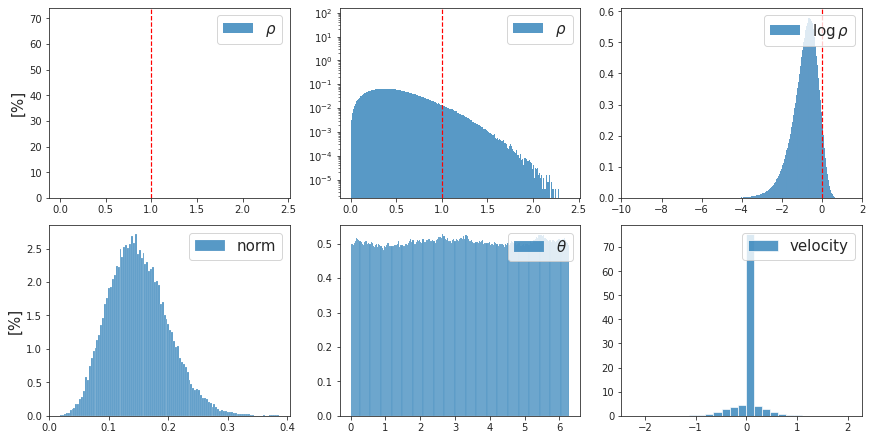

In [8]:
plot_opticflow_hist(stim);

In [7]:
np.round(np.quantile(stim.ravel(), [0.5, 0.95, 0.97, 0.99]), 2)

array([0.  , 0.38, 0.51, 0.76])

### Get ready to fit

In [8]:
cfg = ConfigReadout(n_ftrs_enc, act_fn='softplus', dropout=0.1, n_lags=3)
readout = Readout3D(cfg).to(tr.device)

optim = torch.optim.AdamW(readout.parameters(), lr=0.01, weight_decay=0.1)
optim_schedule = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, T_max=10000, eta_min=1e-5)

In [9]:
print(readout)
readout.print()

Readout3D(
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (act_fn): Softplus(beta=1, threshold=20)
  (criterion): PoissonNLLLoss()
  (fc): Linear(in_features=5312, out_features=1, bias=True)
  (kernel): Conv3d(1, 1, kernel_size=(4, 4, 13), stride=(1, 1, 1), padding=(0, 0, 12))
)

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  Readout3D  |   5.5 K    |
|     ---     |    ---     |
|      fc     |   5.3 K    |
|    kernel   |    210     |
+-------------+------------+

In [10]:
tau = 2000
valid_inds = np.arange(len(stim) - tau)
rng = get_rng()

In [11]:
from base.utils_model import AvgrageMeter
nll = AvgrageMeter()

In [ ]:
...

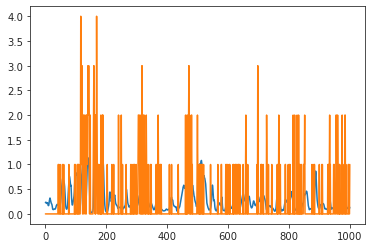

In [24]:
if readout.criterion.log_input:
    r_pred = to_np(pred.exp().ravel())
else:
    r_pred = to_np(pred.ravel())
r_obs = to_np(y.ravel())
plt.plot(r_pred)
plt.plot(r_obs)

In [25]:
sp_stats.pearsonr(r_pred, r_obs)

(0.30062489422541105, 2.4673355742859296e-22)

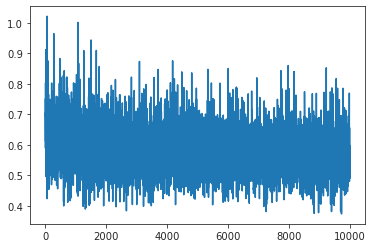

In [26]:
plt.plot(loss_all)

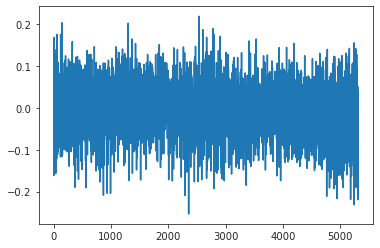

In [27]:
w = to_np(readout.fc.weight)
plt.plot(w.ravel());

In [28]:
w = to_np(readout.kernel.weight.squeeze())
w.shape

(4, 4, 13)

In [29]:
u, s, v = sp_lin.svd(flatten_arr(w))
s *= 100 / s.sum()
s

array([37.972874  , 13.76079   ,  9.271777  ,  7.1559744 ,  6.1720996 ,
        5.9854865 ,  4.7761025 ,  4.4420204 ,  3.0949137 ,  2.7392943 ,
        2.125438  ,  1.769711  ,  0.73351187], dtype=float32)

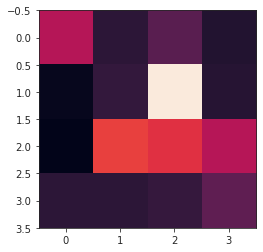

In [30]:
plt.imshow(u[:, 0].reshape(4, 4))

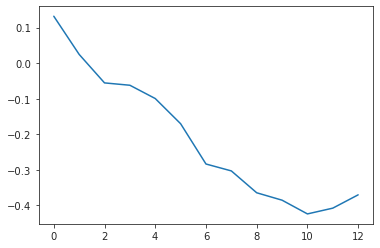

In [31]:
plt.plot(v[0])

In [32]:
stim.shape, stim_r.shape

((72000, 2, 19, 19), (36000, 2, 19, 19))

In [33]:
readout.eval()

timepoints = range(1000)
x = tr.to(stim_r[timepoints])
*_, ftr = vae.xtract_ftr(x, full=True)
pred = readout(ftr['enc'])

In [34]:
r_pred = to_np(pred[intvl].ravel())
r_obs = np.nanmean(spks_r[0], 0)
r2 = sk_metric.r2_score(
    y_true=r_obs,
    y_pred=r_pred,
) * 100

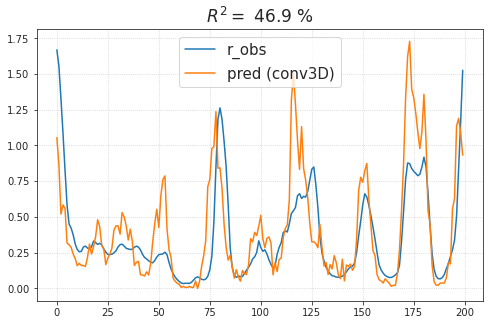

In [35]:
fig, ax = create_figure(1, 1, (8, 5))
plt.plot(r_pred, label='r_obs')
plt.plot(r_obs, label='pred (conv3D)')
plt.title(r"$R^2 = $" + f" {r2:0.1f} %", fontsize=17)
plt.legend(fontsize=15)
ax.grid()
plt.show()

In [69]:
from readout.readout import _Readout

class Readout3D(_Readout):
    def __init__(self, cfg: ConfigReadout, **kwargs):
        super(Readout3D, self).__init__(cfg, **kwargs)
        self._init()
        if self.verbose:
            self.print()

    def forward(self, ftr: dict):
        ftr = self.process(ftr)
        if self.cfg.pool == 'none':
            out = []
            for s, x in ftr.items():
                m = self.kernel[str(s)]
                out.append(self._op(x, m))
            out = torch.cat(out, dim=1)
        else:
            out = self._op(ftr, self.kernel)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc(out)
        if self.act_fn is not None:
            out = self.act_fn(out)
        return out

    def _op(self, x: torch.Tensor, m: nn.Module):
        x = torch.movedim(x, 0, -1).unsqueeze(1)
        x = m(x).squeeze()[..., :-self.pad].T
        return x.contiguous()

    def _init(self):
        self.pad = self.cfg.n_lags - 1
        kws = dict(
            in_channels=1,
            out_channels=1,
            padding=(0, 0, self.pad),
        )
        if self.cfg.pool == 'none':
            self.kernel = nn.ModuleDict()
            for s in self.cfg.n_ftrs:
                kws['kernel_size'] = (s, s, self.cfg.n_lags)
                self.kernel[str(s)] = nn.Conv3d(**kws)
        else:
            kws['kernel_size'] = (
                self.scale,
                self.scale,
                self.cfg.n_lags,
            )
            self.kernel = nn.Conv3d(**kws)
        # fn = AddNorm('weight', nn.Conv3d).get_fn()
        # self.apply(fn)
        return

In [70]:
# from readout.readout import Readout3D

cfg = ConfigReadout(
    n_ftrs_enc,
    act_fn='none',
    pool='max',
    dropout=0.1,
    n_lags=23,
)
readout = Readout3D(cfg).to(tr.device)

optim = torch.optim.AdamW(readout.parameters(), lr=0.01, weight_decay=0.05)
optim_schedule = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, T_max=10000, eta_min=1e-5)

In [71]:
print(readout)
readout.print()

Readout3D(
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (criterion): PoissonNLLLoss()
  (fc): Linear(in_features=5312, out_features=1, bias=True)
  (kernel): Conv3d(1, 1, kernel_size=(4, 4, 23), stride=(1, 1, 1), padding=(0, 0, 22))
)

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  Readout3D  |   5.7 K    |
|     ---     |    ---     |
|      fc     |   5.3 K    |
|    kernel   |    369     |
+-------------+------------+

In [72]:
from base.common import AddNorm, nn
fn = AddNorm('spectral', nn.Conv3d, n_power_iterations=5, name='weight').get_fn()
readout.apply(fn)

Readout3D(
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (criterion): PoissonNLLLoss()
  (fc): Linear(in_features=5312, out_features=1, bias=True)
  (kernel): ParametrizedConv3d(
    1, 1, kernel_size=(4, 4, 23), stride=(1, 1, 1), padding=(0, 0, 22)
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): _SpectralNorm()
      )
    )
  )
)

In [73]:
tau = 500
valid_inds = np.arange(len(stim) - tau)
rng = get_rng()

In [74]:
from base.utils_model import AvgrageMeter
nll = AvgrageMeter()

In [75]:
lr_all = []
loss_all = []

readout.train()

n_iters = range(10000)
pbar = tqdm(n_iters)
for e in pbar:
    if e % 200 == 0:
        if e > 0:
            loss_all.append(nll.avg)
        nll = AvgrageMeter()
    i = rng.choice(valid_inds)
    timepoints = range(i, i + tau)
    m = mask[timepoints]
    m[:readout.cfg.n_lags] = 0.0
    if not m.sum():
        continue
    x = stim[timepoints]
    y = spks[timepoints]

    x, y, m = tr.to([x, y, m])
    *_, ftr = vae.xtract_ftr(x, full=True)

    pred = readout(ftr['enc'])
    loss = readout.loss(pred, y, m)

    optim.zero_grad()
    loss.backward()
    optim.step()
    optim_schedule.step()
    
    nll.update(loss.item())
    lr_all.append(optim.param_groups[0]['lr'])
    pbar.set_description(f"nll = {nll.avg:0.6f}, lr = {lr_all[-1]:0.2g}")

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
## Spectral instead of weight norm

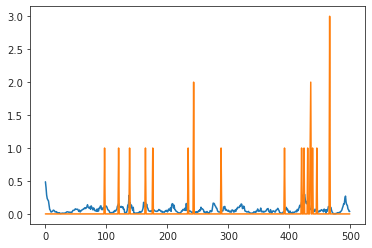

In [76]:
if readout.criterion.log_input:
    r_pred = to_np(pred.exp().ravel())
else:
    r_pred = to_np(pred.ravel())
r_obs = to_np(y.ravel())
plt.plot(r_pred)
plt.plot(r_obs)

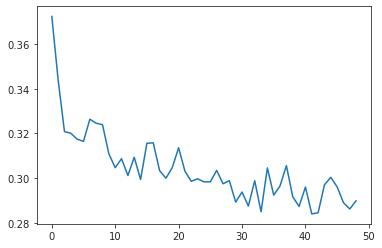

In [77]:
plt.plot(loss_all)

In [78]:
readout.eval()

timepoints = range(1000)
x = tr.to(stim_r[timepoints])
*_, ftr = vae.xtract_ftr(x, full=True)
pred = readout(ftr['enc'])

In [79]:
if readout.criterion.log_input:
    r_pred = to_np(pred[intvl].ravel().exp())
else:
    r_pred = to_np(pred[intvl].ravel())

r_obs = np.nanmean(spks_r[0], 0)
r2 = sk_metric.r2_score(
    y_true=r_obs,
    y_pred=r_pred,
) * 100

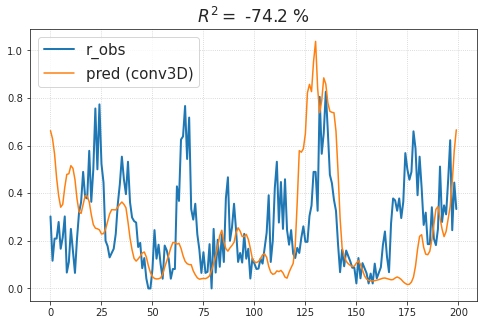

In [80]:
fig, ax = create_figure(1, 1, (8, 5))
plt.plot(r_obs, color='C0', lw=2, label='r_obs')
plt.plot(r_pred, color='C1', label='pred (conv3D)')
plt.title(r"$R^2 = $" + f" {r2:0.1f} %", fontsize=17)
plt.legend(fontsize=15)
ax.grid()
plt.show()

In [81]:
w = to_np(readout.kernel.weight.squeeze())
w.shape

(4, 4, 23)

In [82]:
u, s, v = sp_lin.svd(flatten_arr(w))
s *= 100 / s.sum()
s

array([25.923286 , 13.223895 , 11.789564 ,  9.047119 ,  8.103548 ,
        6.797981 ,  5.221989 ,  4.0866194,  2.9533722,  2.8845804,
        2.5596275,  2.128457 ,  1.8613448,  1.4729837,  1.087319 ,
        0.8583167], dtype=float32)

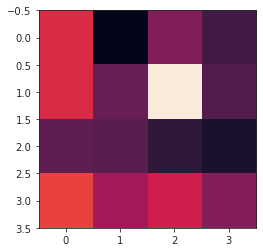

In [83]:
plt.imshow(u[:, 0].reshape(4, 4))

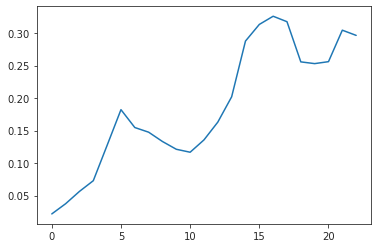

In [84]:
plt.plot(v[0])